In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

Incorporating Feedback:

**Justified new rush hour timing (5 am to 10 pm and 2 pm - 6 pm)**

**Justified new commuter trip length (<=30 minutes)**

In [15]:
%%bigquery finding_commuter_rush_hours

SELECT EXTRACT(HOUR FROM start_date) AS hour, FROM `bigquery-public-data.san_francisco.bikeshare_trips` 
WHERE EXTRACT(DAYOFWEEK FROM start_date) NOT IN (1, 7)

Downloading: 100%|██████████| 871994/871994 [00:01<00:00, 576521.40rows/s] 


In [16]:
finding_commuter_rush_hours.head()

,hour
0,2
1,2
2,0
3,4
4,2


Text(0, 0.5, 'Number of Trips')

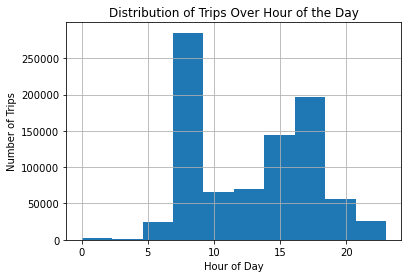

In [17]:
finding_commuter_rush_hours.hist()
plt.title('Distribution of Trips Over Hour of the Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')

Based on the hourly trip frequency corresponding to weekdays, the peak times of day with the greatest frequency of trips are from hours 5 to 10, or 5 am to 10 am for the commute from residence to work/school... etc and from hours 14 to 18, or 2 pm to 6 pm for the commute from work/school... etc to residence. Although these are rough estimations, they better encapsulate the rush hour period for commuters since these times are based directly on the hourly trip frequency for weekdays. Please see this rush hour time change reflected in remainder of report.

# Project 1

## Question 1: What are the 5 most popular trips that you would call "commuter trips"?

Defining characteristics of "commuter" trips:
1. During rush hour (Monday-Friday, 5am-10am and 2pm-6pm)
2. Roughly <= 30 minutes in duration
3. Different start and end points, but on same day
4. Commuters as most likely classified as subscribers

**Criteria 1: During rush hour (Monday-Friday, 5am-10am and 2pm-6pm)**

In [18]:
%%bigquery commuter_rush_hour_trips

SELECT CASE EXTRACT(DAYOFWEEK FROM start_date)
    WHEN 1 THEN "Sunday"
    WHEN 2 THEN "Monday"
    WHEN 3 THEN "Tuesday"
    WHEN 4 THEN "Wednesday"
    WHEN 5 THEN "Thursday"
    WHEN 6 THEN "Friday"
    WHEN 7 THEN "Saturday"
END AS day, 
CASE WHEN EXTRACT(HOUR FROM start_date) >= 5 OR EXTRACT(HOUR FROM start_date) <= 10 THEN "To"
    WHEN EXTRACT(HOUR FROM start_date) >= 14 OR EXTRACT(HOUR FROM start_date) <= 18 THEN "From"
    END AS commute_label
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE EXTRACT(DAYOFWEEK FROM start_date) NOT IN (1, 7) AND ((EXTRACT(HOUR FROM start_date) >= 5 AND EXTRACT(HOUR FROM start_date) <= 10) OR (EXTRACT(HOUR FROM start_date) >= 14 AND EXTRACT(HOUR FROM start_date) <= 18)) 

Downloading: 100%|██████████| 685214/685214 [00:01<00:00, 482604.60rows/s] 


In [19]:
commuter_rush_hour_trips.head()

,day,commute_label
0,Friday,To
1,Friday,To
2,Friday,To
3,Friday,To
4,Friday,To


Text(0, 0.5, 'Number of Trips')

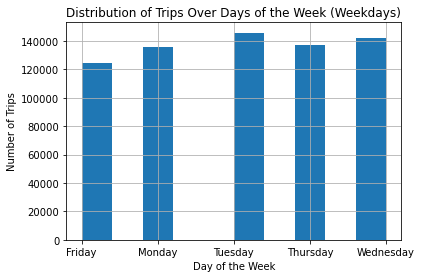

In [20]:
commuter_rush_hour_trips.day.hist()
plt.title('Distribution of Trips Over Days of the Week (Weekdays)')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')

It appears that the greatest frequency of trips is on Wednesday, the middle of the week, which makes sense as it is a "hump" day and everyone is going to work or school (not common to have public holidays or time off in the middle of the week). Conversely, the lowest frequency of trips is on Friday, which is the start of the weekend and also is justifiable as employees and/or students may tend to get lazier at the end of the week and not prefer biking for transportation as a result.

In [21]:
commuter_rush_hour_trips.commute_label.value_counts()

To    685214
Name: commute_label, dtype: int64

It is notable that all rush hour trips on weekdays are in the morning, from 5:00 am to 10:00 am, as opposed to the afternoon, from 2:00 pm to 6:00 pm. This indicates that all rush hour commuters commute to work or school...etc but not from. This could be due to having a ride, possibly from a coworker or classmate, from work to home or variability in terms of when the commuter plans to leave work or school. It could also be due to the fact that the planning required to rent out a bike is easier to do at home when the commuter is free/getting ready for work, and may be harder to do at work ahead of time. This also makes sense since, if the commuter needs a ride from work as well, it may be more economically feasible to purchase a bike rather than rent one every day.

**Criteria 2: Roughly <= 30 minutes in duration**

In [22]:
%%bigquery commuter_trip_durations

SELECT duration_sec as duration_seconds, 
    CAST(ROUND(duration_sec / 60) AS INT64) AS duration_minutes,
    CAST(ROUND(duration_sec / 3600) AS INT64) AS duration_hours, 
    CAST(ROUND(duration_sec / 86400) AS INT64) AS duration_days
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE  CAST(ROUND(duration_sec / 60) AS INT64) <= 30
ORDER BY duration_sec DESC

Downloading: 100%|██████████| 937150/937150 [00:01<00:00, 771752.02rows/s] 


In [23]:
commuter_trip_durations.head()

,duration_seconds,duration_minutes,duration_hours,duration_days
0,1829,30,1,0
1,1829,30,1,0
2,1829,30,1,0
3,1829,30,1,0
4,1829,30,1,0


<AxesSubplot:>

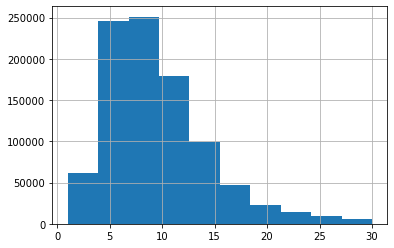

In [24]:
commuter_trip_durations.duration_minutes.hist()

It appears that most commuter trips are between 0 and 30 minutes with some outliers that display up to 45 minutes in trip length. Therefore, we can assume that commuter trips are generally under 30 minutes long.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


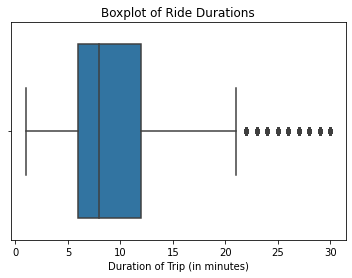

In [25]:
ax = sns.boxplot(commuter_trip_durations['duration_minutes'])
ax.set(xlabel='Duration of Trip (in minutes)', title = "Boxplot of Ride Durations");

In [26]:
commuter_trip_durations.mean()

duration_seconds    558.163000
duration_minutes      9.311184
duration_hours        0.000928
duration_days         0.000000
dtype: float64

The average trip is about 10 minutes, which makes sense as this is a reasonable and enjoyable duration for renting a bike without making the commuter excessively tired or drained before work or school. On the contrary, a longer commute may require a commuter to choose an alternative mode of transportation, such as bus, BART, or rideshare service like Uber or Lyft. It could also be that biking serves as a middle man between locations like home-BART or CalTrain-work... etc.

In [27]:
commuter_trip_durations.std()

duration_seconds    300.155931
duration_minutes      5.010364
duration_hours        0.030455
duration_days         0.000000
dtype: float64

The standard deviation of about 6 minutes indicates the average trip is in the range from 4 to 16 minutes, which is not too short and not too long, justifying the use of a bike for the commute.

Text(0, 0.5, 'Number of Trips')

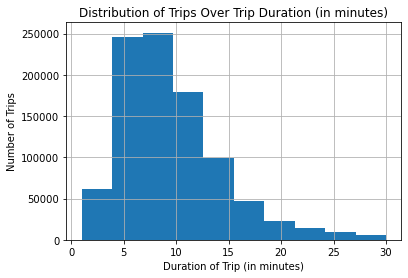

In [28]:
commuter_trip_durations.duration_minutes.hist()
plt.title('Distribution of Trips Over Trip Duration (in minutes)')
plt.xlabel('Duration of Trip (in minutes)')
plt.ylabel('Number of Trips')

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


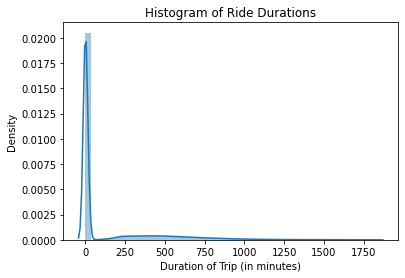

In [29]:
ax = sns.distplot(commuter_trip_durations)
ax.set(xlabel='Duration of Trip (in minutes)', 
       title = "Histogram of Ride Durations");

**Criteria 3: Different start and end points, but on same day**

In [30]:
%%bigquery daily_commutes

SELECT start_date, start_station_name, end_date, end_station_name from bigquery-public-data.san_francisco.bikeshare_trips 
WHERE start_station_name != end_station_name and EXTRACT(DAY FROM start_date) = EXTRACT(DAY FROM end_date) and
EXTRACT(MONTH FROM start_date) = EXTRACT(MONTH FROM end_date) and EXTRACT(YEAR FROM start_date) = EXTRACT(YEAR FROM end_date)

Downloading: 100%|██████████| 949768/949768 [00:01<00:00, 548181.34rows/s] 


In [31]:
daily_commutes.head()

,start_date,start_station_name,end_date,end_station_name
0,2016-02-14 05:25:00+00:00,Kaiser Hospital,2016-02-14 05:42:00+00:00,Mezes
1,2015-10-05 16:41:00+00:00,Sequoia Hospital,2015-10-05 16:51:00+00:00,Mezes
2,2016-02-23 12:00:00+00:00,San Mateo County Center,2016-02-23 12:22:00+00:00,Mezes
3,2015-12-25 13:17:00+00:00,San Mateo County Center,2015-12-25 13:35:00+00:00,Mezes
4,2016-03-03 21:54:00+00:00,Redwood City Public Library,2016-03-03 22:22:00+00:00,Mezes


Text(0, 0.5, 'Number of Trips')

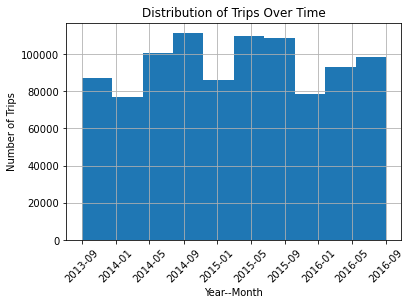

In [32]:
daily_commutes.start_date.hist()
plt.xticks(rotation=45)
plt.title("Distribution of Trips Over Time")
plt.xlabel("Year--Month")
plt.ylabel("Number of Trips")

Although there were more trips with the same start and end day and different start and end stations in the years 2014 and 2015, as opposed to the start and end of the data collection, 2013 and 2016, there is no clear spread in the distribution.

**Criteria 4: Riders are classified as subscribers**

In [33]:
%%bigquery commuter_types

SELECT subscriber_type as rider_type, COUNT(*) as count FROM bigquery-public-data.san_francisco.bikeshare_trips GROUP BY subscriber_type

Downloading: 100%|██████████| 2/2 [00:01<00:00,  1.80rows/s]


In [34]:
commuter_types

,rider_type,count
0,Customer,136809
1,Subscriber,846839


In [35]:
print(np.round(100 * (int(commuter_types[commuter_types['rider_type'] == 'Subscriber']['count'])/
     (int(commuter_types[commuter_types['rider_type'] == 'Customer']['count']) + int(commuter_types[commuter_types['rider_type'] == 'Subscriber']['count'])))))

86.0


This indicates that about 86% of the riders who took trips were subcribers. This makes sense as someone who is more likely to use the bike rental service on a day-to-day basis, such as for a commute, is also more likely to invest in a long-term plan like a subscription.  

**Combination**

In [37]:
%%bigquery top_5_commutes

SELECT COUNT(*) as count, start_station_name as start_station, end_station_name as end_station FROM
(SELECT CASE EXTRACT(DAYOFWEEK FROM start_date)
    WHEN 1 THEN "Sunday"
    WHEN 2 THEN "Monday"
    WHEN 3 THEN "Tuesday"
    WHEN 4 THEN "Wednesday"
    WHEN 5 THEN "Thursday"
    WHEN 6 THEN "Friday"
    WHEN 7 THEN "Saturday"
END AS day, 
CASE WHEN EXTRACT(HOUR FROM start_date) >= 5 OR EXTRACT(HOUR FROM start_date) <= 10 THEN "To"
    WHEN EXTRACT(HOUR FROM start_date) >= 14 OR EXTRACT(HOUR FROM start_date) <= 18 THEN "From"
    END AS commute_label, 
duration_sec as duration_seconds, 
    CAST(ROUND(duration_sec / 60) AS INT64) AS duration_minutes,
    CAST(ROUND(duration_sec / 3600) AS INT64) AS duration_hours, 
    CAST(ROUND(duration_sec / 86400) AS INT64) AS duration_days,
start_date, start_station_name, 
end_date, end_station_name
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE EXTRACT(DAYOFWEEK FROM start_date) NOT IN (1, 7) AND 
((EXTRACT(HOUR FROM start_date) >= 5 AND EXTRACT(HOUR FROM start_date) <= 10) OR (EXTRACT(HOUR FROM start_date) >= 14 AND EXTRACT(HOUR FROM start_date) <= 18)) AND
start_station_name != end_station_name AND 
EXTRACT(DAY FROM start_date) = EXTRACT(DAY FROM end_date) AND
EXTRACT(MONTH FROM start_date) = EXTRACT(MONTH FROM end_date) AND 
EXTRACT(YEAR FROM start_date) = EXTRACT(YEAR FROM end_date) AND 
subscriber_type = 'Subscriber' AND CAST(ROUND(duration_sec / 60) AS INT64) <= 30)
GROUP BY start_station_name, end_station_name 
ORDER BY COUNT(*) DESC 
LIMIT 5

Downloading: 100%|██████████| 5/5 [00:01<00:00,  3.76rows/s]


In [38]:
top_5_commutes

,count,start_station,end_station
0,6022,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th
1,5985,2nd at Townsend,Harry Bridges Plaza (Ferry Building)
2,5634,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th)
3,5447,Harry Bridges Plaza (Ferry Building),2nd at Townsend
4,5329,Temporary Transbay Terminal (Howard at Beale),San Francisco Caltrain (Townsend at 4th)


In [39]:
top_5_commutes["trip"] = top_5_commutes["start_station"] + " to " + top_5_commutes["end_station"]
top_5_commutes

,count,start_station,end_station,trip
0,6022,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,San Francisco Caltrain 2 (330 Townsend) to Tow...
1,5985,2nd at Townsend,Harry Bridges Plaza (Ferry Building),2nd at Townsend to Harry Bridges Plaza (Ferry ...
2,5634,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),Embarcadero at Folsom to San Francisco Caltrai...
3,5447,Harry Bridges Plaza (Ferry Building),2nd at Townsend,Harry Bridges Plaza (Ferry Building) to 2nd at...
4,5329,Temporary Transbay Terminal (Howard at Beale),San Francisco Caltrain (Townsend at 4th),Temporary Transbay Terminal (Howard at Beale) ...


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'San Francisco Caltrain 2 (330 Townsend) to\nTownsend at 7th'),
 Text(0, 1, '2nd at Townsend to\nHarry Bridges Plaza (Ferry Building)'),
 Text(0, 2, 'Embarcadero at Folsom to\nSan Francisco Caltrain (Townsend at 4th)'),
 Text(0, 3, 'Harry Bridges Plaza (Ferry Building) to\n2nd at Townsend'),
 Text(0, 4, 'Temporary Transbay Terminal (Howard at Beale) to\nSan Francisco Caltrain (Townsend at 4th)')]

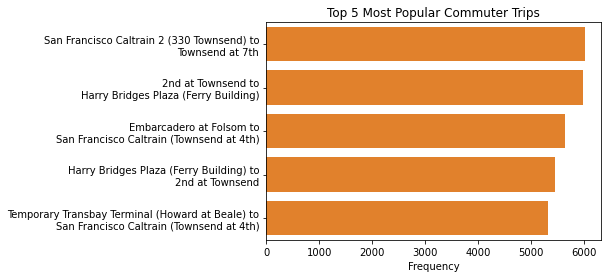

In [40]:
ax = sns.barplot(top_5_commutes["count"], top_5_commutes["trip"], color = 'tab:orange')
ax.set(xlabel = "Frequency", ylabel = "", title = "Top 5 Most Popular Commuter Trips")
ax.set_yticklabels(top_5_commutes["start_station"] + " to\n" + top_5_commutes["end_station"])

Therefore, the 5 most popular trips that I would call "commuter trips", in order of most to least popular are:

1. San Francisco Caltrain 2 (330 Townsend) to Townsend at 7th
2. 2nd at Townsend to Harry Bridges Plaza (Ferry Building)
3. Embarcadero at Folsom to San Francisco Caltrain (Townsend at 4th)
3. Harry Bridges Plaza (Ferry Building) to 2nd at Townshend
4. Temporary Transbay Terminal (Howard at Beale) to San Francisco Caltrain (Townshend at 4th)


Popular commuter trips also involve the San Francisco Caltrain stations. This makes sense as it is economically efficient to take a bike to a bus station to avoid walking.

2 of the top 5 most common commuter trips are either to or from 2nd at Townsend. This could be because there is a lot of housing within the Townsend area and individuals there may be taking the ferry at the Ferry Building, Caltrain, or other form of intermediate commute to commute to work in other Bay Area cities. 


In order to derive these trips, I specified criteria for a "commute":

- During rush hour (Monday-Friday, 5am-10am and 2pm-6pm)
- Roughly <= 30 minutes in duration
- Different start and end points, but on same day
- Commuters classified as subscribers

## Question 2: What are your recommendations for offers?

In [33]:
%%bigquery all

SELECT COUNT(*) as count FROM bigquery-public-data.san_francisco.bikeshare_trips

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.25s/rows]


In [34]:
all

,count
0,983648


In [40]:
%%bigquery commuter_trips 

SELECT COUNT(*) as count FROM
(SELECT CASE EXTRACT(DAYOFWEEK FROM start_date)
    WHEN 1 THEN "Sunday"
    WHEN 2 THEN "Monday"
    WHEN 3 THEN "Tuesday"
    WHEN 4 THEN "Wednesday"
    WHEN 5 THEN "Thursday"
    WHEN 6 THEN "Friday"
    WHEN 7 THEN "Saturday"
END AS day, 
CASE WHEN EXTRACT(HOUR FROM start_date) >= 5 OR EXTRACT(HOUR FROM start_date) <= 10 THEN "To"
    WHEN EXTRACT(HOUR FROM start_date) >= 14 OR EXTRACT(HOUR FROM start_date) <= 18 THEN "From"
    END AS commute_label,
duration_sec as duration_seconds, 
    CAST(ROUND(duration_sec / 60) AS INT64) AS duration_minutes,
    CAST(ROUND(duration_sec / 3600) AS INT64) AS duration_hours, 
    CAST(ROUND(duration_sec / 86400) AS INT64) AS duration_days,
start_date, start_station_name, 
end_date, end_station_name
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE EXTRACT(DAYOFWEEK FROM start_date) NOT IN (1, 7) AND 
((EXTRACT(HOUR FROM start_date) >= 5 AND EXTRACT(HOUR FROM start_date) <= 10) OR (EXTRACT(HOUR FROM start_date) >= 14 AND EXTRACT(HOUR FROM start_date) <= 18)) AND
start_station_name != end_station_name AND 
EXTRACT(DAY FROM start_date) = EXTRACT(DAY FROM end_date) AND
EXTRACT(MONTH FROM start_date) = EXTRACT(MONTH FROM end_date) AND 
EXTRACT(YEAR FROM start_date) = EXTRACT(YEAR FROM end_date) AND 
subscriber_type = 'Subscriber')

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.16s/rows]


In [41]:
commuter_trips

,count
0,629984


In [42]:
print(np.round(100 * (int(commuter_trips['count'])/
     (int(all['count'])))))

64.0


Even though I conservatively defined commutes, about 64% (more than half) of the total trips in the dataset are commuter trips. This allows me to conclude that commuting is a dominant use case for the bike share service so we should look into how to encourage commuters to use the program or be more consistent in using it if they already are. 

In [43]:
%%bash
bq query --use_legacy_sql=FALSE --format=csv '
SELECT EXTRACT(DAYOFWEEK FROM start_date) AS day, subscriber_type, COUNT(trip_id) AS num_trips
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
GROUP BY day, subscriber_type
ORDER BY day, subscriber_type' > days_and_subscribers.csv

Waiting on bqjob_r57c7ae31a22bb228_0000017ca1bec5bc_1 ... (0s) Current status: DONE   


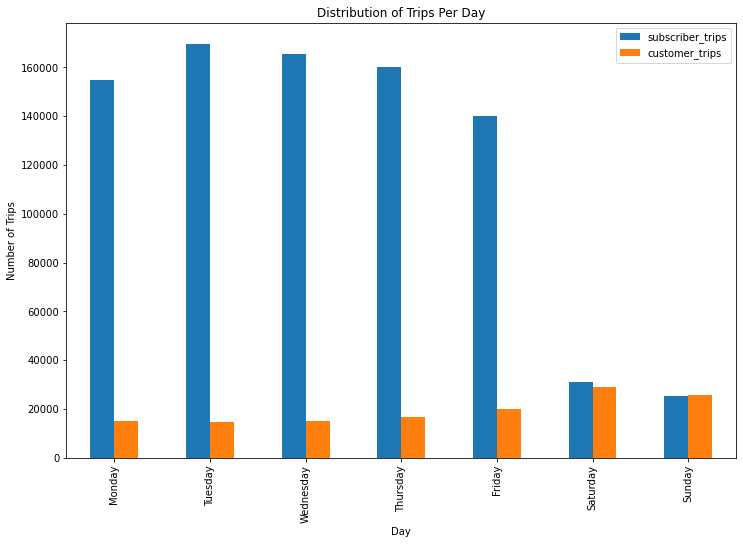

In [44]:
trips_for_weekdays = pd.read_csv('days_and_subscribers.csv')

customers = trips_for_weekdays[trips_for_weekdays['subscriber_type'] == 'Customer']
customers = customers.set_index('day')
customers.columns = ['customer', 'customer_trips']

subscribers = trips_for_weekdays[trips_for_weekdays['subscriber_type'] == 'Subscriber']
subscribers = subscribers.set_index('day')
subscribers.columns = ['subscriber', 'subscriber_trips']

joined = subscribers.join(customers)
joined = joined[['subscriber_trips','customer_trips']]
joined.rename({1: 'Sunday', 2:'Monday', 3:'Tuesday', 4:'Wednesday', 5:'Thursday', 6:'Friday', 7:'Saturday'},
          axis='index', inplace=True)
joined = joined.loc[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], :]
ax = joined.plot(kind ='bar', figsize = (12, 8), title = 'Distribution of Trips Per Day')
ax.set_xlabel('Day')
ax.set_ylabel('Number of Trips')
ax.legend()

Since most people who ride during week days are commuters and they hold subscriptions, increasing usage may involve making subscription services more appealing to continue, provide greater benefits to ensure longetivity of subscriptions or ssubscription renewals, or attract commuters without subscriptions to purchase them. 

In terms of the weekends (Saturday and Sunday), it appear that the number of trips made my subscribers and non-subscribers are roughly equivalent. This makes sense as someone who rides on only the weekend, or for tourism or travel purposes most likely during the weekend, is not likely to invest in a subscription. Providing some kind of discount for weekend usage for non-subscribers as well may increase bike use on weekends since the number of weekend trips is relatively low.

In [45]:
%%bigquery trip_locations

SELECT station_id, latitude, longitude FROM bigquery-public-data.san_francisco.bikeshare_stations

Downloading: 100%|██████████| 74/74 [00:01<00:00, 52.58rows/s]


In [46]:
trip_locations.head()

,station_id,latitude,longitude
0,4,37.333988,-121.894902
1,37,37.448598,-122.159504
2,35,37.444521,-122.163093
3,32,37.385956,-122.083678
4,84,37.342725,-121.895617


In [47]:
import geopandas as gpd
from shapely.geometry import Point

geometry = [Point(x, y) for x, y in zip(trip_locations['latitude'], trip_locations['longitude'])]

In [48]:
geo_df = gpd.GeoDataFrame(trip_locations, geometry = geometry)
geo_df = geo_df.set_crs(epsg=4326)

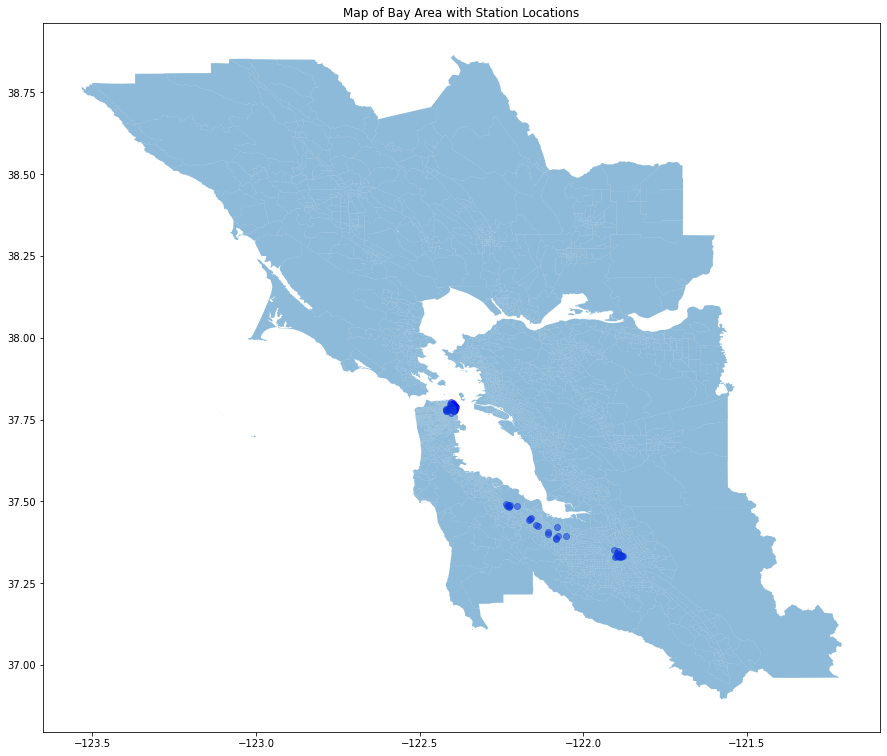

In [49]:
gdf_polys = gpd.read_file('geospatial_items/tm960wp6354.shp')
gdf_polys = gdf_polys.to_crs(epsg=4326)

gdf_points = gpd.GeoSeries([Point(x, y) for x, y in zip(trip_locations['longitude'], trip_locations['latitude'])])
gdf_points = gdf_points.set_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(15,15))
gdf_points.plot(ax=ax, alpha=0.5, color='blue', marker = 'o', zorder = 1, aspect=1) 
gdf_polys.plot(ax=ax, alpha=0.5, marker = 'o', zorder = 2, aspect=1) 
plt.title('Map of Bay Area with Station Locations')
plt.show()

As expected, most of the stations are located in the SF region and the southern Peninsula, where Bay Area commuters are concentrated for work. In terms of SF, most stations are concentrated near the financial district. There are also scattered stations near the San Mateo, Palo Alto, and Sunnyvale areas, which contain a lot of tech jobs and hence attract commuters. There also appear to be some in San Jose, which is also becoming a tech hub to some extent. These are expected to be the locations and sub regions with the most jobs so it makes sense for there to be prevalent stations, especially for commuters.

In [50]:
%%bash
bq query --use_legacy_sql=FALSE --format=csv '
SELECT table.subscriber_type as subscriber_type, table.time_range AS duration, COUNT(table.trip_id) AS number
 FROM (SELECT subscriber_type, trip_id,
     CASE
       WHEN duration_sec <= 1800 THEN "0 - 30 mins"
       WHEN duration_sec > 1800 AND duration_sec < 3600 THEN "30 mins - 1 hr"
       WHEN duration_sec >= 3600 AND duration_sec < 7200 THEN "1 - 2 hrs"
       WHEN duration_sec >= 7200 AND duration_sec < 10800 THEN "2 - 3 hrs"
       WHEN duration_sec >= 10800 AND duration_sec < 14400 THEN "3 - 4 hrs"
       WHEN duration_sec >= 14400 AND duration_sec < 18000 THEN "4 - 5 hrs"
       WHEN duration_sec >= 18000 AND duration_sec < 21600 THEN "5 - 6 hrs"
       WHEN duration_sec >= 21600 AND duration_sec < 25200 THEN "6 - 7 hrs"
       WHEN duration_sec >= 25200 AND duration_sec < 28800 THEN "7 - 8 hrs"
       WHEN duration_sec >= 28800 AND duration_sec < 32400 THEN "8 - 9 hrs"
       WHEN duration_sec >= 32400 AND duration_sec < 36000 THEN "9 - 10 hrs"
       ELSE "Over 10 hrs"
     END AS time_range
   FROM
     `bigquery-public-data.san_francisco.bikeshare_trips`) as table
GROUP BY subscriber_type, duration
ORDER BY number DESC' > durations.csv

Waiting on bqjob_r24eef0e511a2e509_0000017ca1bf10dd_1 ... (0s) Current status: DONE   


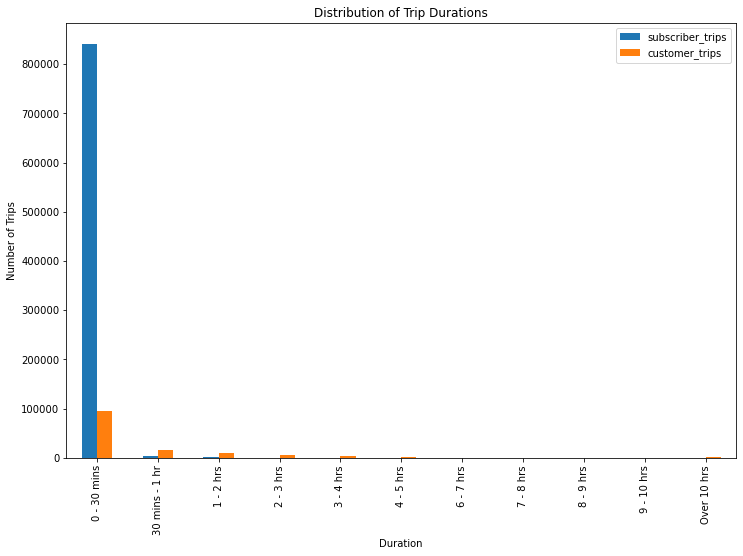

In [51]:
durations = pd.read_csv('durations.csv')

customers = durations[durations['subscriber_type'] == 'Customer']
customers = customers.set_index('duration')
customers.columns = ['customer', 'customer_trips']

subscribers = durations[durations['subscriber_type'] == 'Subscriber']
subscribers = subscribers.set_index('duration')
subscribers.columns = ['subscriber', 'subscriber_trips']

joined = subscribers.join(customers)
joined = joined[['subscriber_trips','customer_trips']]
joined = joined.loc[['0 - 30 mins', '30 mins - 1 hr', '1 - 2 hrs', '2 - 3 hrs',
             '3 - 4 hrs', '4 - 5 hrs', '6 - 7 hrs', '7 - 8 hrs', '8 - 9 hrs', '9 - 10 hrs', 'Over 10 hrs'], :]

ax = joined.plot(kind='bar', figsize = (12, 8), title = 'Distribution of Trip Durations')
ax.set_xlabel('Duration')
ax.set_ylabel('Number of Trips')
ax.legend()

Based on the plot, it appears that subscribers have shorter trips that are less than 30 min, which makes sense since a short commute would make users more inclined to to use bikes as a mode of transportation. Conversely, most of the longer trips, greater than 30 minutes are associated with non-subcribers. 

Most trips in general are on the shorter side, < 60 minutes. 

In [52]:
%%bigquery no_bike_stations

SELECT COUNT(status.bikes_available) AS no_bikes,
            station.name,
            status.station_id,
            station.latitude,
            station.longitude,
FROM bigquery-public-data.san_francisco.bikeshare_status AS status
LEFT JOIN bigquery-public-data.san_francisco.bikeshare_stations AS station
ON status.station_id = station.station_id
WHERE status.bikes_available=0
GROUP BY station.name, status.station_id, station.latitude, station.longitude
ORDER BY no_bikes DESC
LIMIT 10

Downloading: 100%|██████████| 10/10 [00:01<00:00,  7.41rows/s]


In [53]:
no_bike_stations

,no_bikes,name,station_id,latitude,longitude
0,44844,2nd at Folsom,62,37.785299,-122.396236
1,44728,Commercial at Montgomery,45,37.794231,-122.402923
2,35903,Embarcadero at Vallejo,48,37.799953,-122.398525
3,32980,Embarcadero at Sansome,60,37.804770,-122.403234
4,32505,Clay at Battery,41,37.795001,-122.399970
5,32027,San Francisco Caltrain (Townsend at 4th),70,37.776617,-122.395260
6,31733,Grant Avenue at Columbus Avenue,73,37.797900,-122.405942
7,30800,Market at 4th,76,37.786305,-122.404966
8,27938,Howard at 2nd,63,37.786978,-122.398108
9,25496,Broadway St at Battery St,82,37.798541,-122.400862


In [54]:
no_bike_stations.head()

,no_bikes,name,station_id,latitude,longitude
0,44844,2nd at Folsom,62,37.785299,-122.396236
1,44728,Commercial at Montgomery,45,37.794231,-122.402923
2,35903,Embarcadero at Vallejo,48,37.799953,-122.398525
3,32980,Embarcadero at Sansome,60,37.804770,-122.403234
4,32505,Clay at Battery,41,37.795001,-122.399970


This represents the top 5 stations that often have no bikes available. 

In [55]:
%%bigquery full_bike_stations

SELECT COUNT(status.bikes_available) AS full_bikes,
            station.name,
            status.station_id,
            station.latitude,
            station.longitude
            FROM bigquery-public-data.san_francisco.bikeshare_status AS status
            LEFT JOIN bigquery-public-data.san_francisco.bikeshare_stations AS station
            ON status.station_id = station.station_id
            WHERE status.bikes_available=station.dockcount
            GROUP BY station.name, status.station_id, station.latitude, station.longitude
            ORDER BY full_bikes DESC
            LIMIT 10

Downloading: 100%|██████████| 10/10 [00:01<00:00,  7.41rows/s]


In [56]:
full_bike_stations.head()

,full_bikes,name,station_id,latitude,longitude
0,39801,San Francisco Caltrain (Townsend at 4th),70,37.776617,-122.395260
1,38400,Embarcadero at Bryant,54,37.787152,-122.388013
2,23932,Embarcadero at Sansome,60,37.804770,-122.403234
3,22086,San Francisco Caltrain 2 (330 Townsend),69,37.776600,-122.395470
4,16528,Civic Center BART (7th at Market),72,37.781039,-122.411748


This represents the top 5 stations that often have the most bikes available. 2 of these stations are also part of the top 5 most popular commuter trips - San Francisco Caltrain (Townsend at 4th), and San Francisco Caltrain 2 (330 Townsend). 

In [57]:
%%bash
bq query --use_legacy_sql=FALSE --format=csv '
SELECT EXTRACT(YEAR FROM start_date) AS year, EXTRACT(MONTH FROM start_date) AS month, COUNT(trip_id) AS number, subscriber_type, 
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
GROUP BY subscriber_type, year, month
ORDER BY subscriber_type, year, month' > monthly_breakdown.csv

Waiting on bqjob_r1a6be7e54983a08e_0000017ca1bf5051_1 ... (0s) Current status: DONE   


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

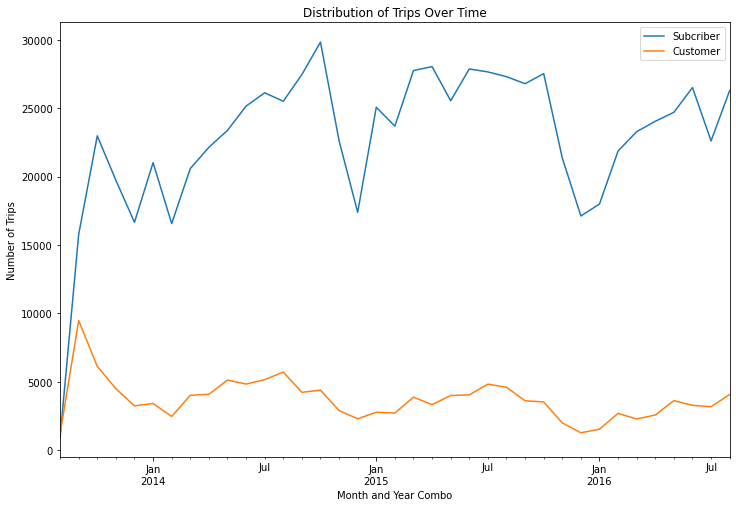

In [58]:
monthly_trips = pd.read_csv('monthly_breakdown.csv')

customers = monthly_trips[monthly_trips['subscriber_type'] == 'Customer']
customers['day'] = 1
customers['date'] = pd.to_datetime(customers[['year','month','day']])
customers = customers.set_index('date')
customers = customers[['subscriber_type','number']]
customers.columns = ['customer', 'customer_trips']

subscribers = monthly_trips[monthly_trips['subscriber_type'] == 'Subscriber']
subscribers['day'] = 1
subscribers['date'] = pd.to_datetime(subscribers[['year','month','day']])
subscribers = subscribers.set_index('date')
subscribers = subscribers[['subscriber_type','number']]
subscribers.columns = ['subscriber', 'subscriber_trips']

joined = subscribers.join(customers)
joined['subscriber_trips'].plot(figsize = (12, 8), label = 'Subcriber')
joined['customer_trips'].plot(figsize = (12, 8), label = 'Customer')

plt.xlabel('Month and Year Combo')
plt.ylabel('Number of Trips')

plt.legend()
plt.title('Distribution of Trips Over Time')
plt.show()

As expected, most subcribers ride bikes during the summer months like June and July, since the weather is warm and pleasant enough for a daily rider to choose a bike as a mode of transport. On the other hand, in terms of customer trips, although the same pattern was observed, it was not as strong since customers may represent those who are visiting or are tourists that may not be as affected by the weather or timing.

## Recommendations:

Based on the insights derived from the data, it is evident that about 64% of all rides are those by commuters, so the majority of Lyft Bay Wheels bike usage can be attributed to commuters, which is why they should be a key focus. Since, on weekdays, subscribers are responsible for a lot more rides compared to commuters (with roughly equal amounts on the weekends) we can also assume that most commuters are subscribers. **In order to encourage commuters to continue using the service, Lyft could offer a corporate membership by partnering with the companies closest to the bike stations to urge targeted employee groups to use the service. To encourage more commuters who haven't tried the service yet, Lyft could also start a program, similar to Bike Share For All, that eliminates the financial barrier to renting bikes. This could give individuals who are not as socioeconomically privileged (those on programs like CalFresh) a discount to use the service or even give the unemployed the chance to use the bikes they rent to transport for their job search efforts - as labor shortage is a pressing issue in the current economy.**

We also observe that the majority of bike stations are located in the SF financial district region and the southern Peninsula (San Mateo, Palo Alto, Sunnyvale, San Jose...etc.), where Bay Area commuters are concentrated for work. Although these station locations are well-designed due to the high concentration of jobs in these cities, based on our research about the most popular stations for commuters, it may also be profitable to strategically position stations near public transit centers or transporation services. For example, some of most popular commuter trips either started or ended at the Harry Bridges Plaza (by the Ferry Building). Moreover, 2 trips relied on the San Francisco Caltrain 2 (330 Townsend) and San Francisco Caltrain 2 (Townsend at 4th) stations. **Since commuters from across the Bay and rely on public transport such as ferries or Caltrain in addition to bikes, partnering up with public transport services to offer discounted rates or a common card-based ticket like a Clipper Pass for travelers who use both platforms would increase the popularity of the service.** 

2 of the stations associated with the top 5 commuter trips are also the stations the most full bikes, so the other top 5 commuter trip stations should definitely be taken into consideration in terms of resource allocation. **Lyft should ensure that this station is stocked with bikes at all times since it is a top 5 commuter ride station. In general, measures should be taken to prioritize bike availability during rush hours (5am-10am and 2pm-6pm) at all stations part of the top 5 commuter rides so the commuters that are already relying on the service are not disspointed and have sufficient resources to commute and maintain trust in the service.** 

Although the usage of the Bay Wheels service increases in summer months, when it is warmer and the weather is more pleasant for bike-riding purposes, it decreases in winter months due to harsher temperatures. However, bike prices are generally lower in winter months like December and January, and individuals are scientifically proven to burn more calories by biking in colder temperatures. **Therefore, in order to incentivise bike usage in colder months and maintain consistency in rides year-round, Lyft should implement some sort of discount or a cheaper rate for the annual subscription service or for the monthly subscription service in winter months like December-February.**

**To encourage more people to initiate using the service, Lyft should waive the $3 unlock fee for first-time riders. Even though this is a small value, it can be encouraging and make Lyft stand out as a more viable option in last minute decision-making.**

Sources https://www.lyft.com/bikes/bay-wheels/bike-share-for-all 

Source: https://bicycleuniverse.com/biking-in-winter/#:~:text=There%20are%20a%20few%20great,but%20every%20little%20bit%20counts